---

Yield Curve PCA Analysis

---

- Given yields $y_t(\tau_j)$ for dates $t=1,\ldots,T$ and 
maturities $\tau_j$, $j=1,\ldots,M$.

- Step 1: Data matrix and centering
$$
    Y \in \mathbb{R}^{T \times M}, \quad Y_{t,j} = y_t(\tau_j),
    \quad \mu_j = \frac{1}{T} \sum_{t=1}^T Y_{t,j}, \quad X_{t,j} = Y_{t,j} - \mu_j.
$$ 

- Step 2: Covariance matrix across maturities

$$
    \Sigma = \frac{1}{T-1} X^\top X \in \mathbb{R}^{M \times M}.
$$

- Step 3: Eigen-decomposition (PCA). Loadings across the curve.

$$
    \Sigma u_k = \lambda_k u_k, \quad k=1,\ldots,M,
    \quad \lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_M \geq 0,
$$

where $u_k \in \mathbb{R}^M$ are the eigevennvectors (loadings). It represents
the shape of the yield curve component.

- Step 4: Scores (factor time series)

$$
    f_k(t) = X_{t,\cdot} \, u_k, \quad t=1,\ldots,T.
$$

- Step 5: Rank-K reconstruction. Let $U = [u_1, \ldots, u_M] \in \mathbb{R}^{M \times M}$
and $F = [f_1, \ldots, f_M] \in \mathbb{R}^{T \times M}$.

$$
    Y^{(K)} = \mathbf{1} \mu^{\top} + \sum_{k=1}^K f_k \, u_k^\top \in \mathbb{R}^{T \times M}
    = \ldots
$$

- Step 6: Explained variance

$$
    \text{EVR}_k = \frac{\lambda_k}{\sum_{j=1}^M \lambda_j}.
$$

- Step 7: Interpretation of components

    - Level (1st component, $u_1$): Parallel shifts in the yield curve.
    - Slope (2nd component, $u_2$): Changes in the steepness of the yield curve.
    - Curvature (3rd component, $u_3$): Changes in the curvature of the yield curve.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data as web
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

In [30]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()

# Constant-maturity Treasury series (percent, not decimals)
fred_tickers = [
    "DGS1MO",
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]

n_mats = len(fred_tickers)

# Load data from local CSV or download from FRED
# Set to False to download from FRED
load = True
if load:
    yields = pd.read_csv("data/yields.csv", index_col=0, parse_dates=True)
else:
    yields = pd.concat(
        [web.DataReader(t, "fred", start, end) for t in fred_tickers], axis=1
    )
df_yields = yields.dropna()
df_yields.columns = fred_tickers

In [31]:
df_yields.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70


In [32]:
# Optional: resample to month-end (reduces missing data/noise)
# yields = yields.resample("M").last()

In [33]:
df_yields /= 100.0  # convert to decimals

In [34]:
Y = df_yields.values  # shape (T, M)
mu = Y.mean(axis=0, keepdims=True)
X = Y - mu  # centered data

# Covariance across maturities (columns)
cov_X = np.cov(X, rowvar=False)  # (M, M)

In [35]:
print(cov_X.shape)

(11, 11)


In [36]:
U, S, U_transpose = np.linalg.svd(cov_X)
explained_variance = S / S.sum()

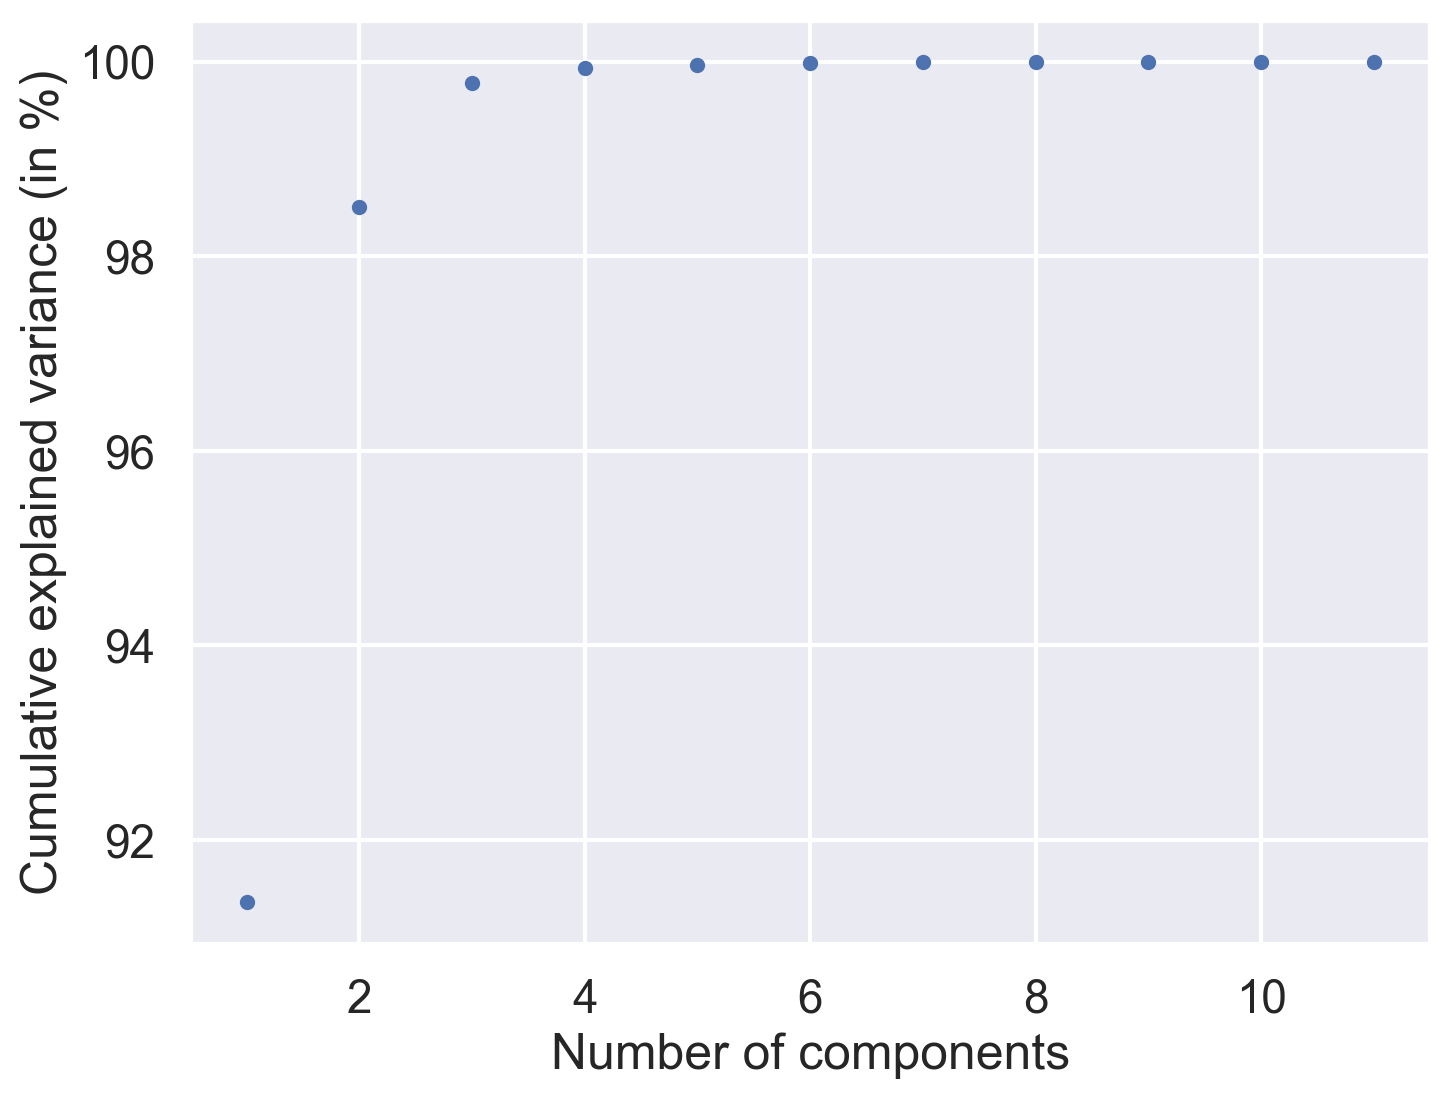

In [73]:
fig, ax = plt.subplots()
ax.plot(range(1, n_mats + 1), 100 * explained_variance.cumsum(), ".")
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance (in %)")
plt.show()

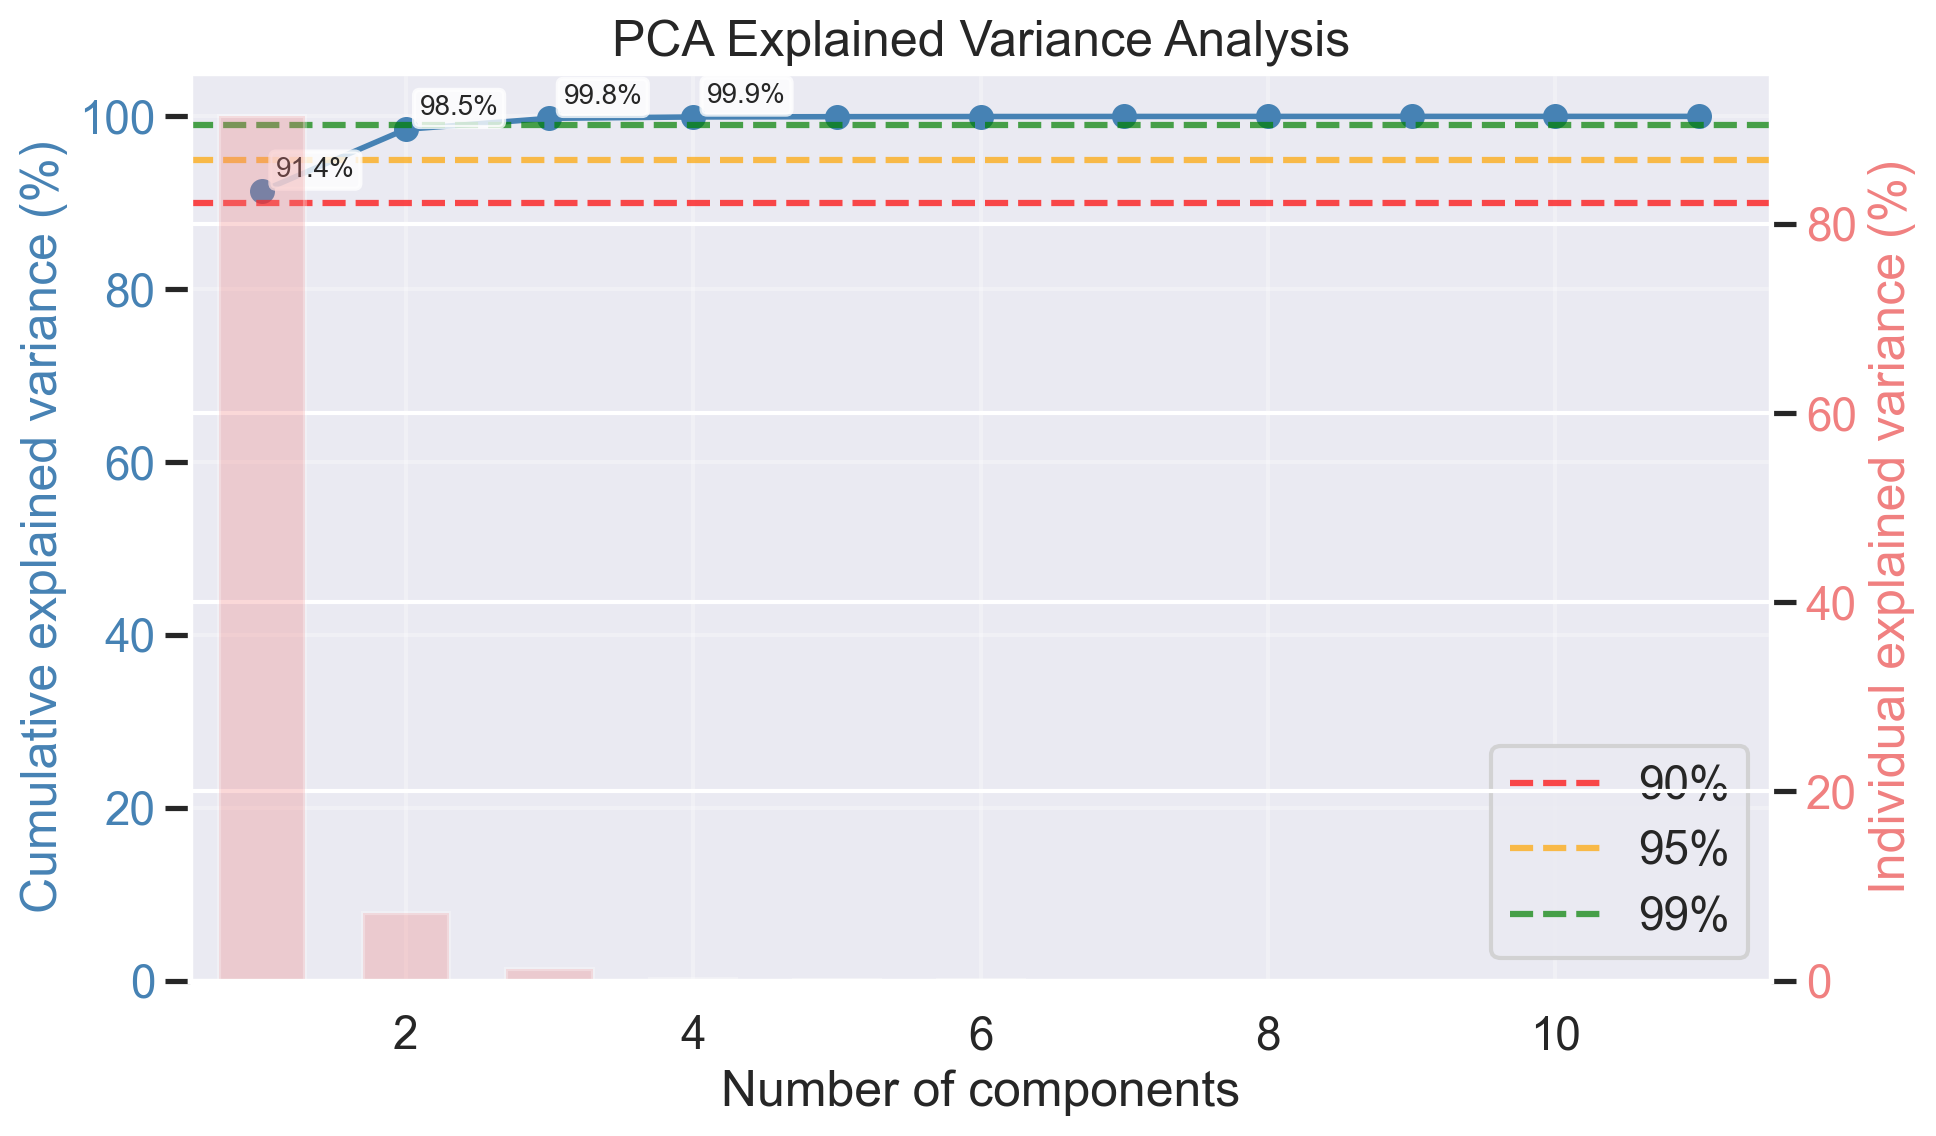

First 3 components explain 99.8% of variance
Components needed for 95% variance: 2
Components needed for 99% variance: 3


In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cumulative explained variance with better styling
ax.plot(
    range(1, n_mats + 1),
    100 * explained_variance.cumsum(),
    "o-",
    linewidth=2,
    markersize=8,
    color="steelblue",
)

# Add individual explained variance as bars
ax2 = ax.twinx()
ax2.bar(
    range(1, n_mats + 1),
    100 * explained_variance,
    alpha=0.3,
    color="lightcoral",
    width=0.6,
    label="Individual",
)

# Add horizontal reference lines
ax.axhline(y=90, color="red", linestyle="--", alpha=0.7, label="90%")
ax.axhline(y=95, color="orange", linestyle="--", alpha=0.7, label="95%")
ax.axhline(y=99, color="green", linestyle="--", alpha=0.7, label="99%")

# Annotations for first few components
for i in range(min(4, n_mats)):
    cumvar = 100 * explained_variance[: i + 1].sum()
    ax.annotate(
        f"{cumvar:.1f}%",
        xy=(i + 1, cumvar),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8),
    )

# Styling
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance (%)", color="steelblue")
ax2.set_ylabel("Individual explained variance (%)", color="lightcoral")
ax.set_title("PCA Explained Variance Analysis")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
ax.set_xlim(0.5, n_mats + 0.5)
ax.set_ylim(0, 105)

# Color the y-axis labels to match the data
ax.tick_params(axis="y", labelcolor="steelblue")
ax2.tick_params(axis="y", labelcolor="lightcoral")

plt.tight_layout()
plt.show()

# Print summary statistics
print(
    f"First 3 components explain {100 * explained_variance[:3].sum():.1f}% of variance"
)
print(
    f"Components needed for 95% variance: {np.argmax(explained_variance.cumsum() >= 0.95) + 1}"
)
print(
    f"Components needed for 99% variance: {np.argmax(explained_variance.cumsum() >= 0.99) + 1}"
)

In [44]:
list_dates = df_yields.index.tolist()

In [54]:
date = dt.datetime(2025, 9, 24)

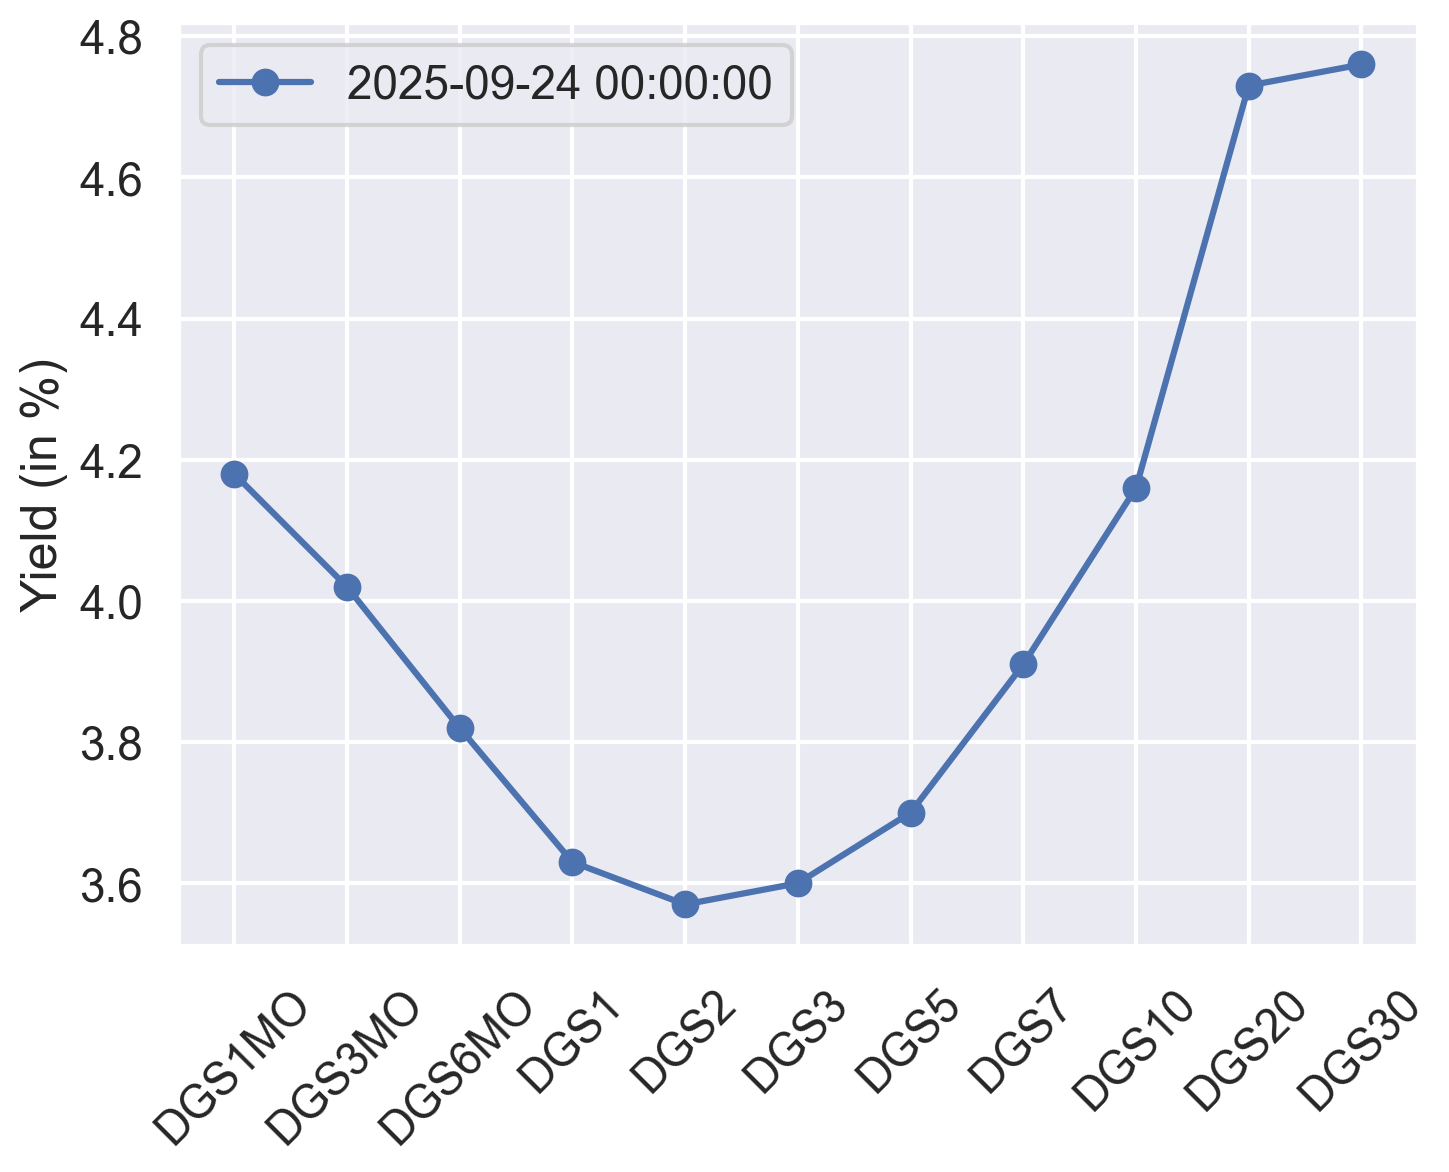

In [57]:
fig, ax = plt.subplots()
ax.plot(fred_tickers, 100 * df_yields.loc[date], "o-", label=f"{date}")
ax.legend()
ax.set_ylabel("Yield (in %)")
ax.tick_params(axis="x", rotation=45)
plt.show()

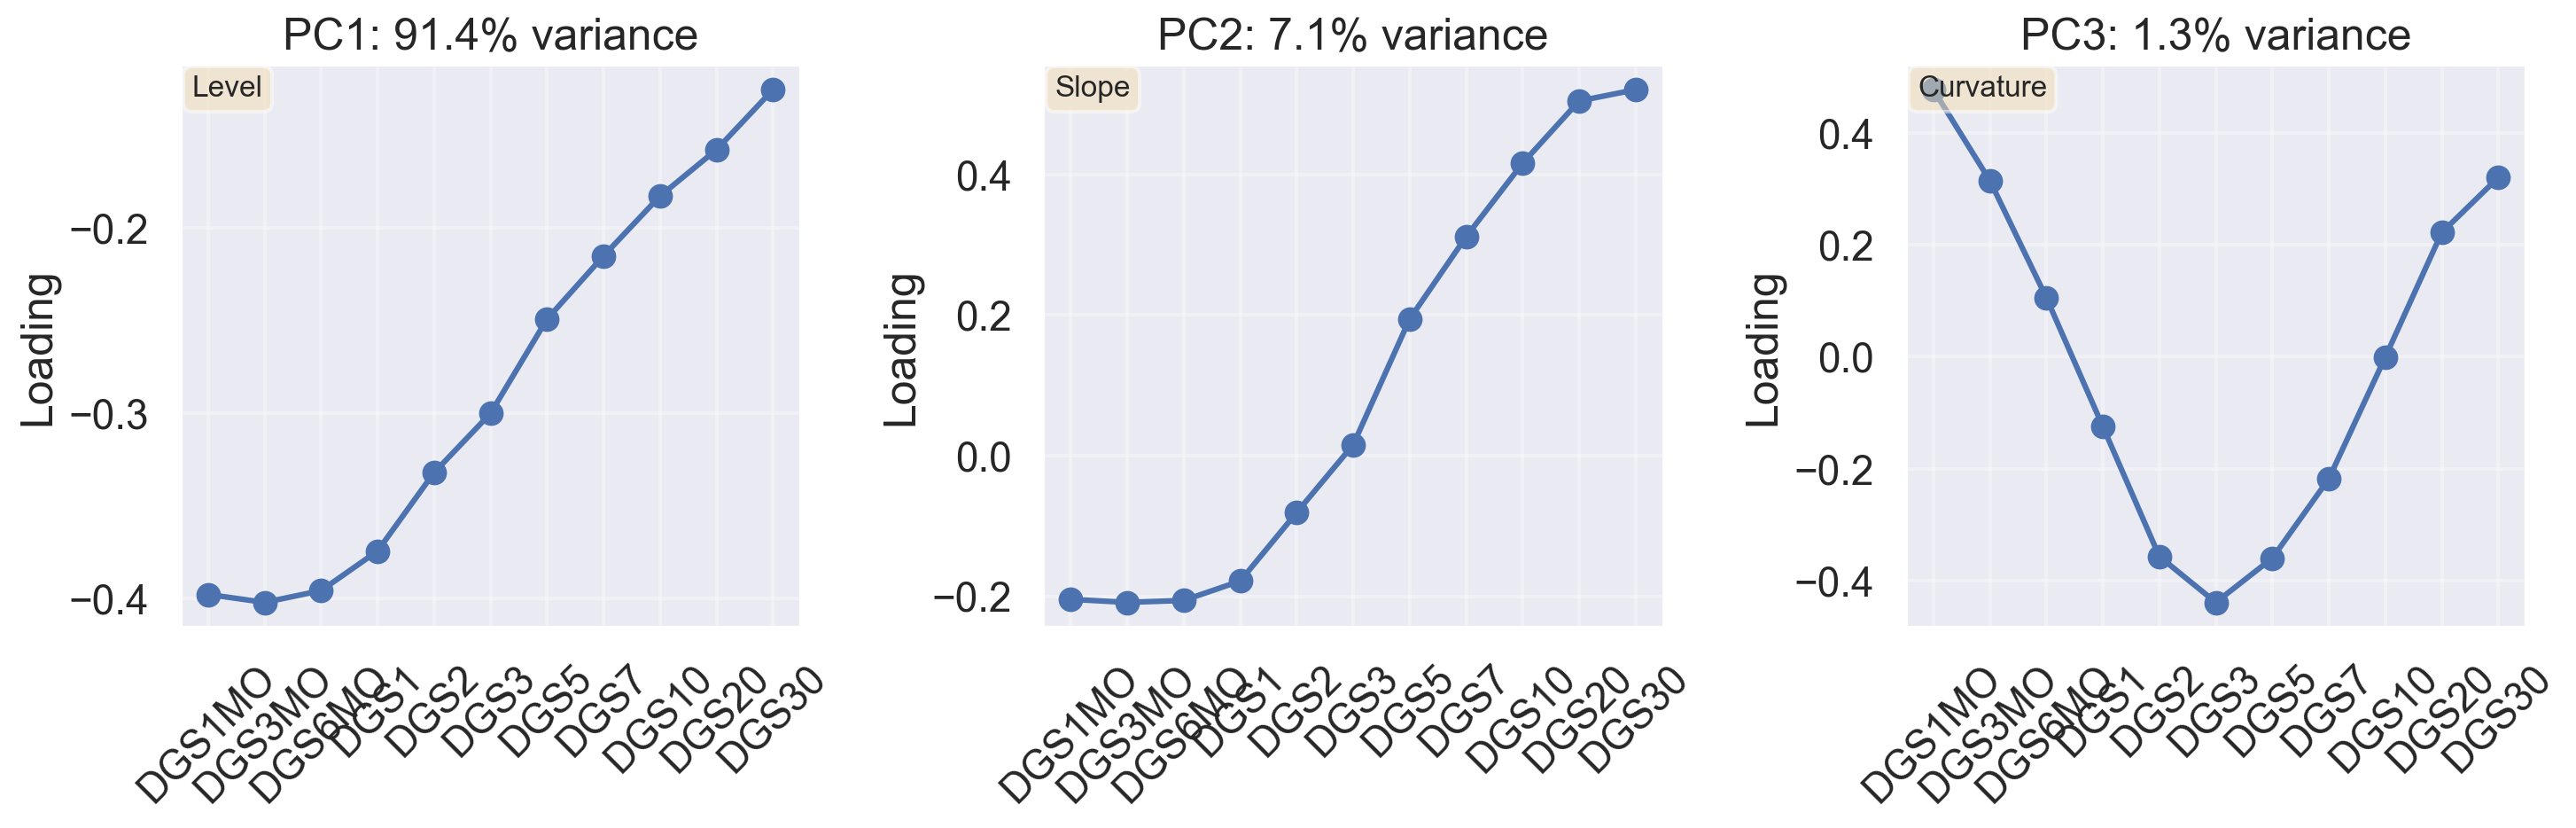

In [65]:
# Compute factor scores (projections onto principal components)
F = X @ U  # shape (T, M) - factor time series

# Plot the first 3 principal component loadings (shapes)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(fred_tickers, U[:, i], "o-")
    axes[i].set_title(f"PC{i + 1}: {explained_variance[i]:.1%} variance")
    axes[i].set_ylabel("Loading")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True, alpha=0.3)

components = ["Level", "Slope", "Curvature"]
for i, comp in enumerate(components):
    axes[i].text(
        0.02,
        0.98,
        comp,
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )
plt.tight_layout()
plt.show()

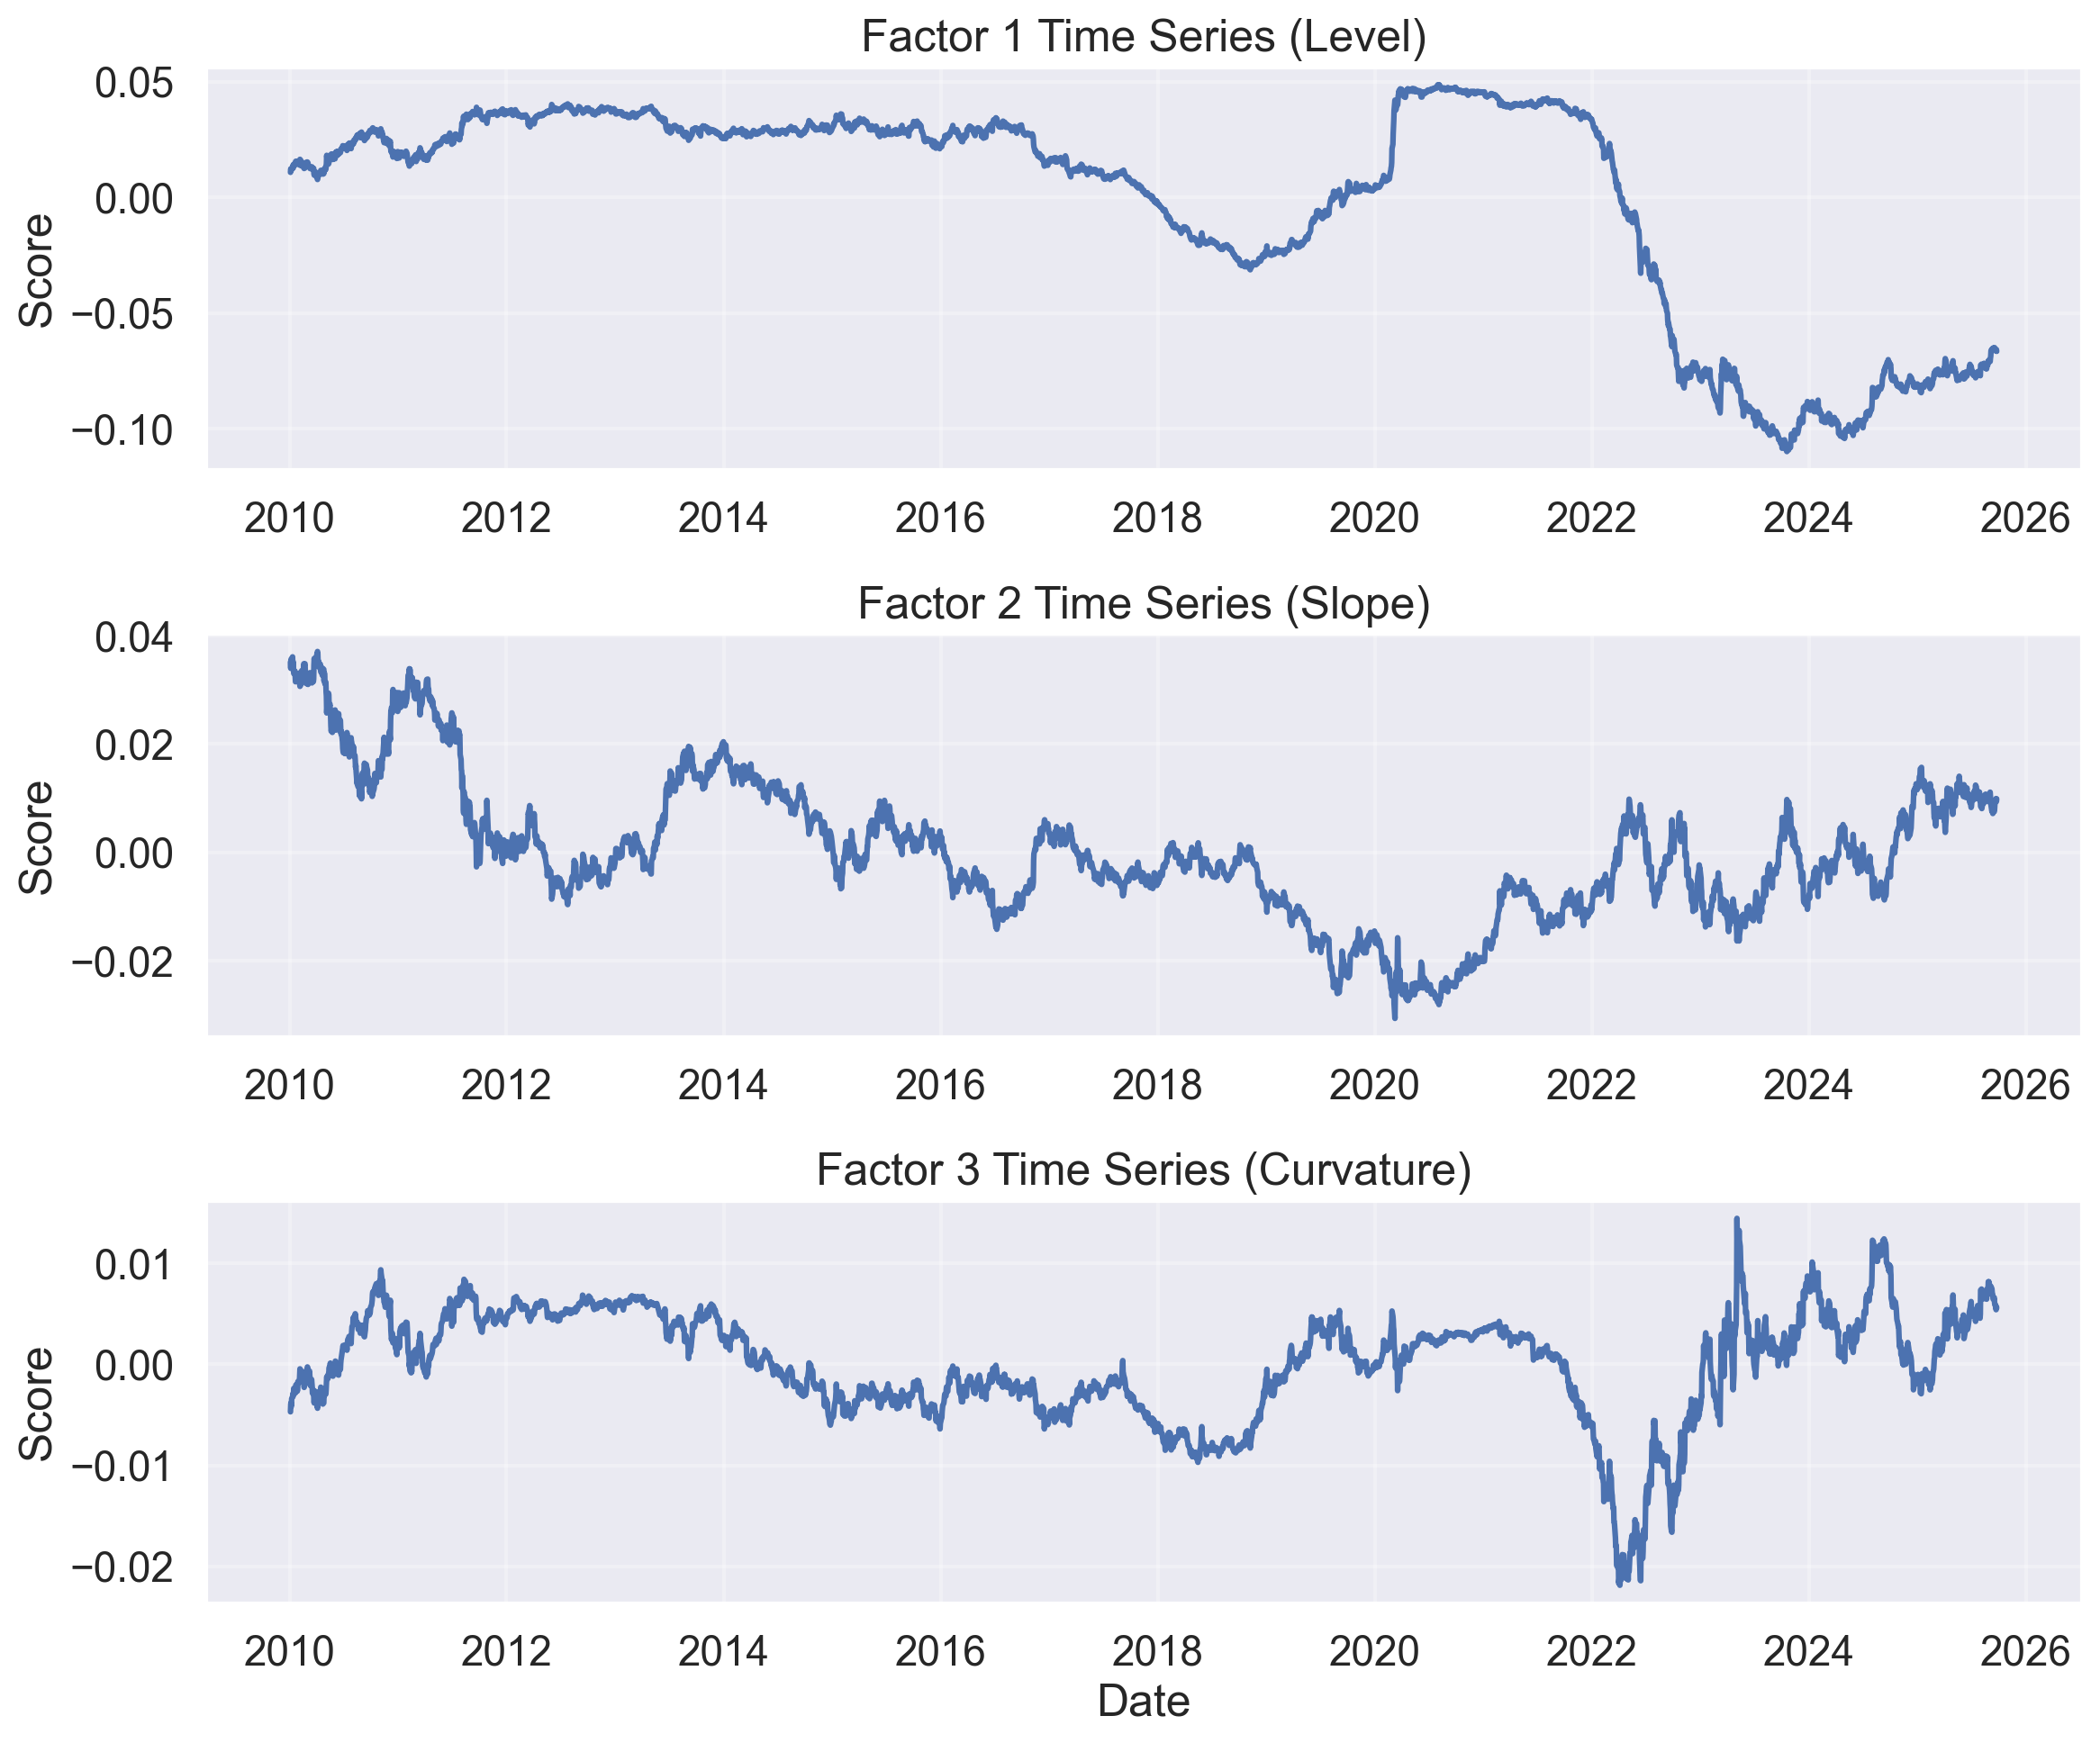

In [66]:
# Plot factor time series (scores over time)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for i in range(3):
    axes[i].plot(df_yields.index, F[:, i])
    axes[i].set_title(f"Factor {i + 1} Time Series ({components[i]})")
    axes[i].set_ylabel("Score")
    axes[i].grid(True, alpha=0.3)
axes[2].set_xlabel("Date")
plt.tight_layout()
plt.show()

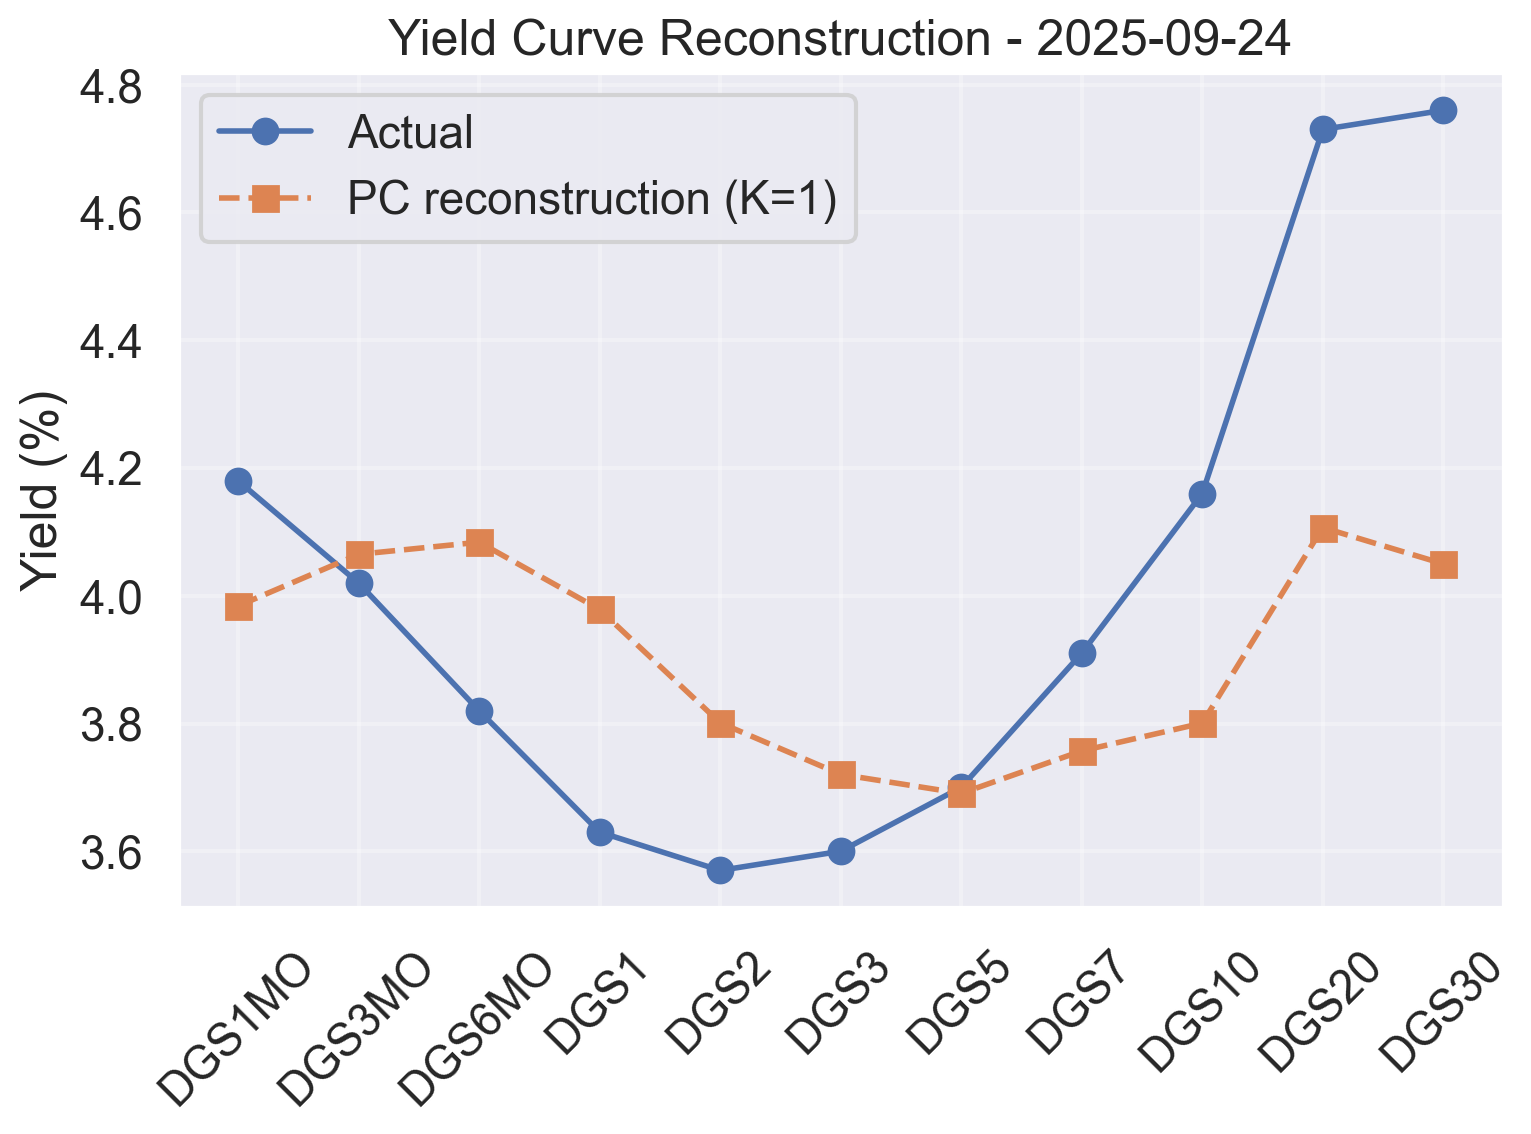

Mean absolute error: 0.0028
Max absolute error: 0.0071


In [75]:
# Reconstruct yield curve using K components and compare with actual
K = 1  # number of components to use
date = dt.datetime(2025, 9, 24)
date_idx = df_yields.index.get_loc(date)

# Original yield curve
y_actual = df_yields.loc[date].values

# Reconstructed yield curve
y_reconstructed = mu.flatten() + F[date_idx, :K] @ U[:, :K].T

fig, ax = plt.subplots()
ax.plot(fred_tickers, 100 * y_actual, "o-", label="Actual", linewidth=2)
ax.plot(
    fred_tickers,
    100 * y_reconstructed,
    "s--",
    label=f"PC reconstruction (K={K})",
    linewidth=2,
)
ax.set_ylabel("Yield (%)")
ax.set_title(f"Yield Curve Reconstruction - {date.strftime('%Y-%m-%d')}")
ax.legend()
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show reconstruction error
error = np.abs(y_actual - y_reconstructed)
print(f"Mean absolute error: {error.mean():.4f}")
print(f"Max absolute error: {error.max():.4f}")